In [1]:
from ce3_compare import set_name, compare, write_submission_txt, grade, set_idm
from feature_model import FeatureModel
import numpy as np

In [2]:
set_name("Anugya", "Sahu")
set_idm("ep42orij")

# Computer exercise 3 (Global post-hoc methods)

- Partial dependence plots (PDP)
- Individual conditional expectation (ICE) <- *local*
- M-Plot
- Accumulated local effects (ALE)
- Permutation feature importance

<img src="pdp_ice_mplot_ale.png" width="1200"/>

## Partial dependence plots (PDP)

In [3]:
bike_path = "datasets/bike/rented_bikes_day_pre.csv"
bike_data = FeatureModel(bike_path)
bike_data.df = bike_data.df.drop(labels=["casual", "registered"], axis=1)
bike_data.add_target("cnt")
bike_data.add_all_features_but_target()

FeatureModel(->Not fully specified yet!)
FeatureModel(cnt ~ -1 + season + yr + mnth + holiday + weekday + workingday + weathersit + temp + hum + windspeed + days_since_01_01_2011 )


In [4]:
X,y = bike_data.return_Xy(train_test_split=False)

In [5]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

def pdp_plot(m, X_train, y_train, X_val=None, kind="average", features=["temp","hum","windspeed"]):
    if X_val is None:
        X_val = X_train
        
    m.fit(X_train, y_train)
    print("R2-score: ", m.score(X_train, y_train))

    pdp = PartialDependenceDisplay.from_estimator(
        m,
        X_val,
        features,
        kind=kind, grid_resolution=100, percentiles=(0,1), method="brute",
        **(dict(pd_line_kw=dict(color="red")) if kind == "both" else {})
    )

    for ax in pdp.axes_[0,:]:
        ax.grid(True)


### PDP for Linear Regression

R2-score:  0.8003086666446174


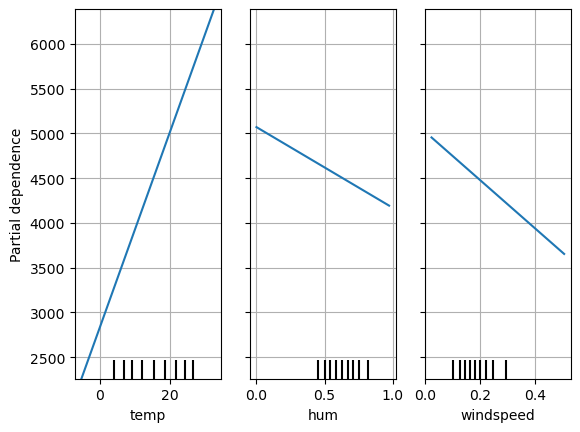

In [6]:
from sklearn.linear_model import LinearRegression

pdp_plot(LinearRegression(), X, y)

Q: What is the meaning of the y-axis in the PDP plot?

Q: What is the meaning of the y-axis for classification?

Q: Does it make sense to create a PDP plot for a LinearRegression?

Q: Does it make sense to create a PDP plot for any inherently explainable model?

### PDP for RandomForestRegressor

C:\Users\anshu\AppData\Local\Temp\ipykernel_1832\2809407492.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9842863690382763


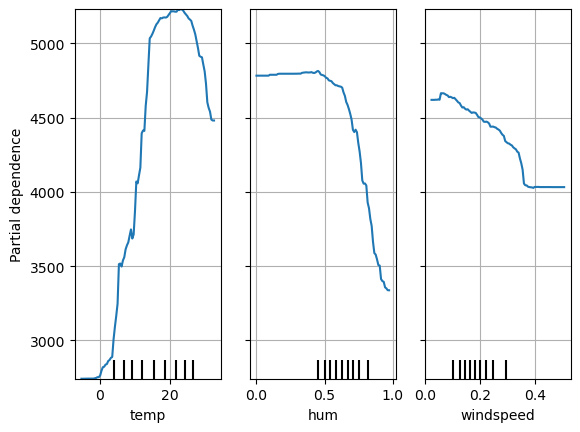

In [7]:
from sklearn.ensemble import RandomForestRegressor

pdp_plot(RandomForestRegressor(), X, y)

### PDP for AdaBoost

C:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2-score:  0.8629736344743056


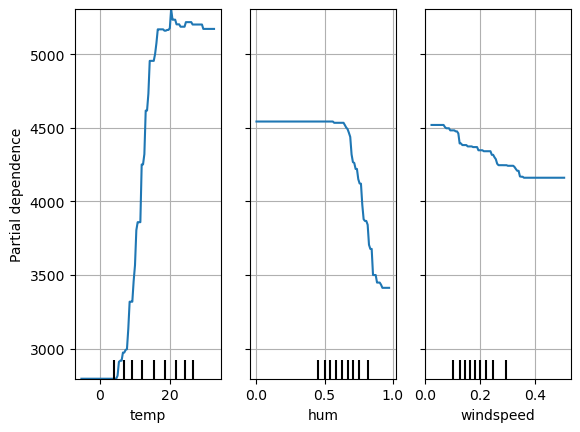

In [8]:
from sklearn.ensemble import AdaBoostRegressor

pdp_plot(AdaBoostRegressor(), X, y)

Q: Does it make sense to use validation data for the averaging?

Q: If you want to explain your model's behaviour, would you use all data / only training data / only validation data?

In [9]:
X_train, y_train, X_val, y_val = bike_data.return_Xy(train_test_split=True)

C:\Users\anshu\AppData\Local\Temp\ipykernel_1832\2809407492.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9824133634175803


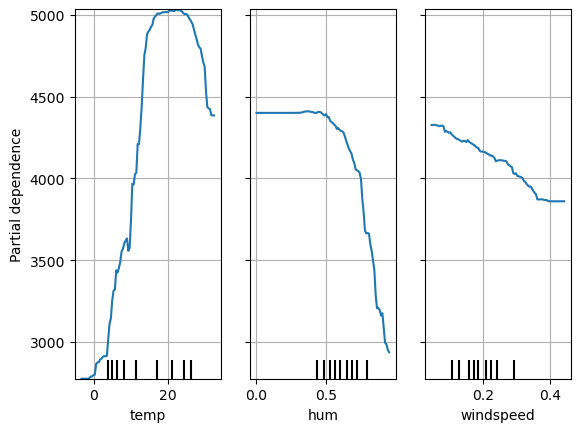

In [10]:
pdp_plot(RandomForestRegressor(), X_train, y_train, X_val)

### Exercise 3.1

Use a `RandomForestRegressor` with `random_state`=1 to predict the number of rented bikes. What is the $\Delta y$ in the last/directly above PDP-plot for the `temp` feature between $20^\circ$ and $0^\circ$? Write a function that returns that exact value.

In [11]:
def ex_3_1() -> float:
    model = RandomForestRegressor(random_state = 1)
    model.fit(X_train, y_train)
    
    pdp = partial_dependence(model, X_val, features = ["temp"], kind = "average",
                             grid_resolution = 100, percentiles = (0, 1), method = "brute")
    temp = np.asarray(pdp["values"])
    
    temp20idx = np.abs(temp - 20).argmin()
    temp0idx = np.abs(temp - 0).argmin()

    y20 = pdp["average"].reshape(-1,1)[temp20idx]
    y0 = pdp["average"].reshape(-1,1)[temp0idx]
    
    return float(y20 - y0)


In [12]:
ex_3_1()

C:\Users\anshu\AppData\Local\Temp\ipykernel_1832\2256136730.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


2352.8066666666678

In [13]:
compare("ex_3_1", ex_3_1)

C:\Users\anshu\AppData\Local\Temp\ipykernel_1832\2256136730.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Great work!


### Exercise 3.2

In the last/directly above PDP-plot for the `windspeed` feature on the x-axis, on which windspeed value is exactly the 5th vertical line? Write a function that returns that exact value.

In [14]:
def ex_3_2() -> float:
    result = np.percentile(X_val["windspeed"], 50)
    return result


In [15]:
ex_3_2()

0.185312

In [16]:
compare("ex_3_2", ex_3_2)

Great work!


### PDP for classification

In [17]:
cancer_path = "datasets/cervical_cancer/risk_factors_cervical_cancer_pre.csv"
cancer_data = FeatureModel(cancer_path)
cancer_data.add_target("Biopsy")
cancer_data.add_all_features_but_target()
X_train, y_train, X_val, y_val = cancer_data.return_Xy(train_test_split=True)

FeatureModel(->Not fully specified yet!)
FeatureModel(Biopsy ~ -1 + Age + Number_of_sexual_partners + First_sexual_intercourse + Num_of_pregnancies + Smokes + Smokes__years + Hormonal_Contraceptives + Hormonal_Contraceptives__years + IUD + IUD__years + STDs + STDs__Number_of_diagnosis + STDs__Time_since_first_diagnosis + STDs__Time_since_last_diagnosis )


C:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2-score:  0.9373177842565598


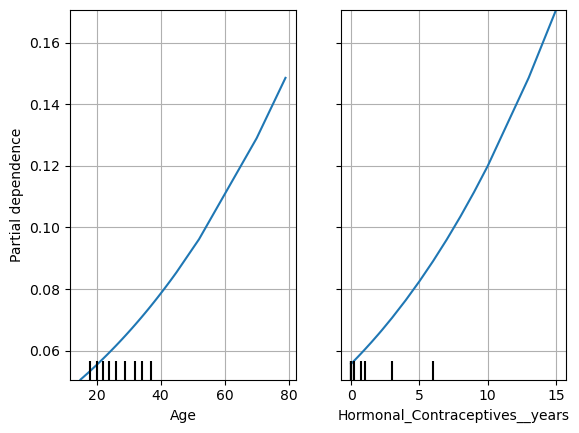

In [18]:
from sklearn.linear_model import LogisticRegression

pdp_plot(LogisticRegression(max_iter=1000), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"])

C:\Users\anshu\AppData\Local\Temp\ipykernel_1832\2809407492.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


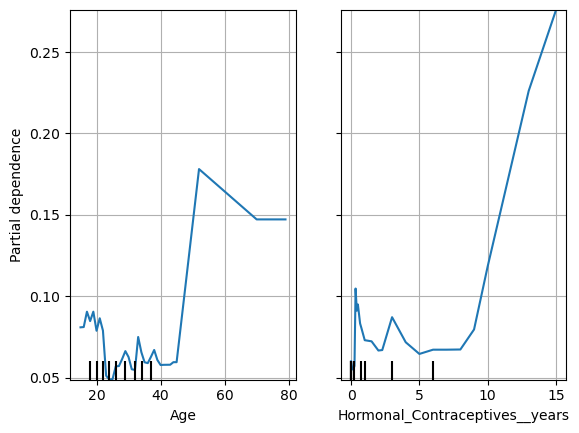

In [19]:
from sklearn.ensemble import RandomForestClassifier
pdp_plot(RandomForestClassifier(), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"])

C:\Users\anshu\AppData\Local\Temp\ipykernel_1832\2809407492.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


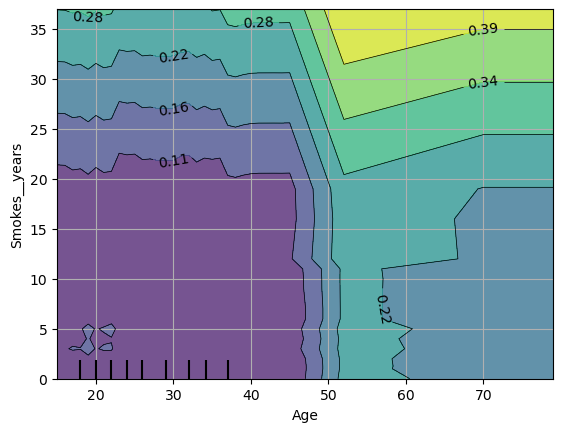

In [20]:
pdp_plot(RandomForestClassifier(), X_train, y_train, X_val=X_val, features=[["Age", "Smokes__years"]])

Q: Does this plot imply that smoking increases the cancer probability regardless of age? Take a close look at the upper-left corner

## Individual conditional expectation (ICE) <- local

C:\Users\anshu\AppData\Local\Temp\ipykernel_1832\2809407492.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


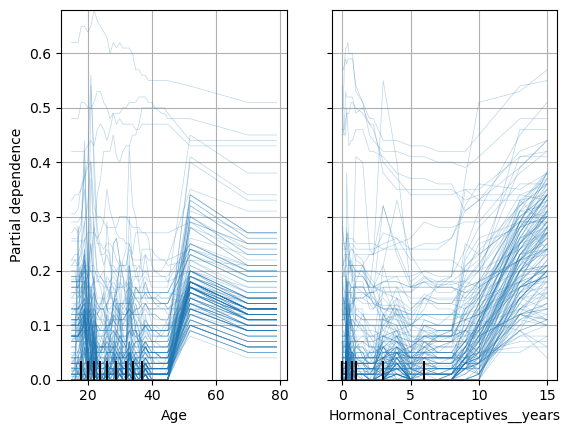

In [21]:
pdp_plot(RandomForestClassifier(random_state=1), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"], kind="individual")

C:\Users\anshu\AppData\Local\Temp\ipykernel_1832\2809407492.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


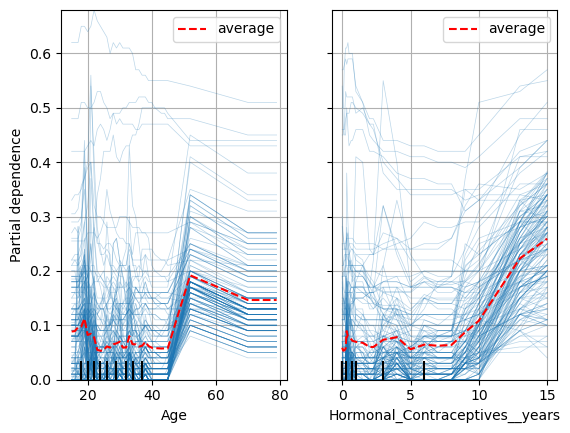

In [22]:
pdp_plot(RandomForestClassifier(random_state=1), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"], kind="both")

### Exercise 3.3

Use a `RandomForestClassifier(random_state=1)`.
What is the predicted cancer probability with an Age of sixty years according to the datapoint with the highest predicted cancer probability of the validation dataset?
Write a function that returns that value.

In [23]:
def ex_3_3() -> float:
    model = RandomForestClassifier(random_state=1)
    model.fit(X_train, y_train)
    X_val["Age"] = 60
    pred_prob = model.predict_proba(X_val)
    result = np.max(pred_prob[:, 1])
    return result

In [24]:
ex_3_3()

C:\Users\anshu\AppData\Local\Temp\ipykernel_1832\1068927868.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


0.52

In [25]:
compare("ex_3_3", ex_3_3)

C:\Users\anshu\AppData\Local\Temp\ipykernel_1832\1068927868.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Great work!


## Accumulated local effects (ALE)

In [26]:
from PyALE import ale # <- This really is more of an m-plot

In [27]:
X,y = bike_data.return_Xy()
regr = RandomForestRegressor(random_state=1)
regr.fit(X,y)

C:\Users\anshu\AppData\Local\Temp\ipykernel_1832\890520154.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X,y)


RandomForestRegressor(random_state=1)

PyALE._ALE_generic:INFO: Continuous feature detected.


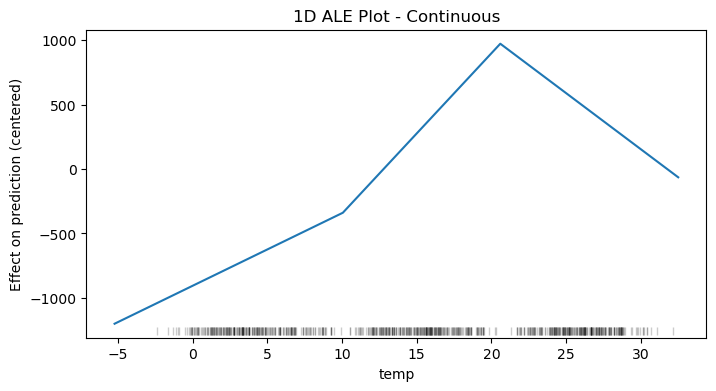

In [28]:
ale_eff = ale(X, regr, ["temp"], grid_size=3, include_CI=False,)

In [29]:
ale_eff

,eff,size
temp,,
-5.220871,-1200.381206,0.0
10.055849,-338.901575,244.0
20.591651,972.902278,244.0
32.498349,-63.894759,243.0


PyALE._ALE_generic:INFO: Continuous feature detected.


                    eff  size  lowerCI_95%  upperCI_95%
temp                                                   
-5.220871  -1304.437601   0.0          NaN          NaN
 1.931288  -1124.719223  37.0 -1151.469293 -1097.969152
 4.141651   -991.390612  36.0 -1035.050161  -947.731062
 5.282623   -771.891422  37.0  -851.772184  -692.010661
 6.805000   -684.808922  36.0  -712.302558  -657.315286
 7.823349   -628.386760  37.0  -649.767757  -607.005763
 9.124356   -533.140371  36.0  -563.883810  -502.396933
 10.604151  -233.696858  37.0  -332.230836  -135.162880
 12.053349   -32.454636  36.0  -143.061396    78.152125
 13.580849   282.745635  37.0   187.392936   378.098333
 15.421651   515.399419  37.0   455.929691   574.869146
 17.027500   620.303585  36.0   588.386054   652.221116
 18.437500   610.524666  37.0   586.045756   635.003576
 20.160849   665.627099  37.0   643.883571   687.370626
 21.688349   656.634730  38.0   645.442051   667.827410
 22.785000   653.150024  34.0   626.471977   679

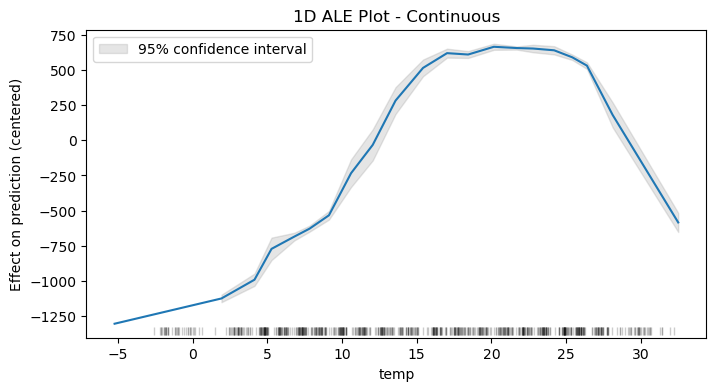

In [30]:
ale_eff = ale(X, regr, ["temp"], grid_size=20, include_CI=True, C=0.95)
print(ale_eff)

In [31]:
ale_table = ale_eff.reset_index()
ale_table

,temp,eff,size,lowerCI_95%,upperCI_95%
0,-5.220871,-1304.437601,0.0,NaN,NaN
1,1.931288,-1124.719223,37.0,-1151.469293,-1097.969152
2,4.141651,-991.390612,36.0,-1035.050161,-947.731062
3,5.282623,-771.891422,37.0,-851.772184,-692.010661
4,6.805000,-684.808922,36.0,-712.302558,-657.315286
5,7.823349,-628.386760,37.0,-649.767757,-607.005763
6,9.124356,-533.140371,36.0,-563.883810,-502.396933
7,10.604151,-233.696858,37.0,-332.230836,-135.162880
8,12.053349,-32.454636,36.0,-143.061396,78.152125
9,13.580849,282.745635,37.0,187.392936,378.098333


### Exercise 3.4

For what *lower* temperature is the expectation of the centered effect on the predicted number of rented bikes exactly zero?
(You may use the table directly above)

In [32]:
def ex_3_4() -> float:
    
    for i in range(len(ale_table)-1):
        if ale_table["eff"][i] > 0:
            result = np.interp(0, [ale_table["eff"][i-1], ale_table["eff"][i]], 
                               [ale_table["temp"][i-1], ale_table["temp"][i]])
            break
        else:
            continue
    return result

In [33]:
ex_3_4()

12.210628229981651

In [34]:
compare("ex_3_4", ex_3_4)

Great work!


### Exercise 3.5 (harder)

Using the above table, what is the 95%-confidence interval of the effect delta when going from `temp=1.931288` to `temp=4.141651`?

*Hint 1*: The 95%-confidence intervall for a normal distribution is at $1.96$ standard deviations

*Hint 2*: https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables

In [36]:
import math
def ex_3_5() ->(float, float):
    lower1 = ale_table[np.isclose(ale_table.iloc[:, 0], 1.931288)]["lowerCI_95%"].values
    upper1 = ale_table[np.isclose(ale_table.iloc[:, 0], 1.931288)]["upperCI_95%"].values
    lower2 = ale_table[np.isclose(ale_table.iloc[:, 0], 4.141651)]["lowerCI_95%"].values
    upper2 = ale_table[np.isclose(ale_table.iloc[:, 0], 4.141651)]["upperCI_95%"].values
    effect1 = ale_table[np.isclose(ale_table.iloc[:, 0], 1.931288)]["eff"].values
    effect2 = ale_table[np.isclose(ale_table.iloc[:, 0], 4.141651)]["eff"].values
    var1 = ((effect1 - lower1)/1.96)**2
    var2 = ((effect2 - lower2)/1.96)**2
    var = var1 + var2
    effect = effect2 - effect1
    lower = effect - 1.96*math.sqrt(var)
    upper = effect + 1.96*math.sqrt(var)
    return (lower[0], upper[0])

In [37]:
ex_3_5()

(82.12585169913822, 184.5313705230839)

In [52]:
compare("ex_3_5", ex_3_5)

Great work!


## Permutation feature importance

Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but *how important this feature is for a particular model*.


In [39]:
from sklearn.inspection import permutation_importance

In [40]:
X_train, y_train, X_val, y_val = bike_data.return_Xy(train_test_split=True)

In [41]:
from sklearn.ensemble import GradientBoostingRegressor
regr = GradientBoostingRegressor(random_state=1)
regr.fit(X_train, y_train)
regr.score(X_val, y_val)

C:\Users\anshu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9021025738192169

In [42]:
r = permutation_importance(regr, X_val, y_val, n_repeats=20, random_state=1)

In [43]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_val.columns[i]:<22} | "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

days_since_01_01_2011  | 0.711 +/- 0.047
temp                   | 0.459 +/- 0.034
hum                    | 0.050 +/- 0.010
windspeed              | 0.030 +/- 0.009
weathersit             | 0.016 +/- 0.007
season                 | 0.011 +/- 0.004
mnth                   | 0.008 +/- 0.003
workingday             | 0.007 +/- 0.002


### Exercise 3.6

Using a `GradientBoostingClassifier(random_state=1)` and `permutation_importance(..., n_repeats=20, random_state=1)`. What is the most important feature of in the cervical cancer dataset?
Write a function that returns this column name.

In [44]:
cancer_path = "datasets/cervical_cancer/risk_factors_cervical_cancer_pre.csv"
cancer_data = FeatureModel(cancer_path)
cancer_data.add_target("Biopsy")
cancer_data.add_all_features_but_target()
X_train, y_train, X_val, y_val = cancer_data.return_Xy(train_test_split=True)

FeatureModel(->Not fully specified yet!)
FeatureModel(Biopsy ~ -1 + Age + Number_of_sexual_partners + First_sexual_intercourse + Num_of_pregnancies + Smokes + Smokes__years + Hormonal_Contraceptives + Hormonal_Contraceptives__years + IUD + IUD__years + STDs + STDs__Number_of_diagnosis + STDs__Time_since_first_diagnosis + STDs__Time_since_last_diagnosis )


In [45]:
from sklearn.ensemble import GradientBoostingClassifier
def ex_3_6() -> str:
    regr = GradientBoostingClassifier(random_state=1)
    regr.fit(X_train, y_train)
    r = permutation_importance(regr, X_val, y_val, n_repeats=20, random_state=1)
    importances = r.importances_mean
    most_important_idx = np.argmax(importances)
    most_important_feature = X_val.columns[most_important_idx]
    return most_important_feature

In [46]:
ex_3_6()

C:\Users\anshu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'First_sexual_intercourse'

In [47]:
compare("ex_3_6", ex_3_6)

C:\Users\anshu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Great work!


Q: Argue why you might question this result?

Q: Repeat `ex_3_6` with a `RandomForestClassifier` instead. What is now the result?

In [53]:
from ce3_compare import scores

In [54]:
scores

{'ex_3_1': True,
 'ex_3_2': True,
 'ex_3_3': True,
 'ex_3_4': True,
 'ex_3_6': True,
 'ex_3_5': True}

In [55]:
write_submission_txt()

In [57]:
grade("ce3_Anugya_Sahu.txt")

'100.0% are correct'